In [1]:
import os.path as osp

import numpy as np
import torch

from sklearn.cluster import DBSCAN
from torch_geometric.data import Data
import torch_geometric.transforms as ttr
from astropy import table as astropy_table

from mptd.reader import get_raw_data
from mptd.simple_message import SimpleMessage
from mptd.plotter import plot_data, plot_clusters, plot_fits_data
from mptd.smallest_enclosing_circle import welzl


In [14]:
from typing import Any


class MPTDData(Data):
    def __init__(self, x = None, edge_index = None, edge_attr = None, y = None, pos = None, **kwargs):
        assert x is None
        super().__init__(x, edge_index, edge_attr, y, pos, **kwargs)

    @property
    def x(self):
        return self.pos
    
    def append(self, other):
        new_edge_index = torch.hstack([self.edge_index, other.edge_index]) \
                         if other.edge_index is not None and self.edge_index is not None else None
        new_edge_attr = torch.hstack([self.edge_attr, other.edge_attr]) \
                        if other.edge_attr is not None and self.edge_attr is not None else None
        
        return MPTDData(x=torch.vstack([self.x, other.x]), 
                        y=torch.hstack([self.y, other.y]), 
                        pos=torch.vstack([self.y, other.y]), 
                        edge_index=new_edge_index,
                        edge_attr=new_edge_attr
                        )    
 
    def getsplice(self, index):
        y = self.y[index] if self.y is not None else None
        pos = self.pos[index] if self.pos is not None else None

        return MPTDData(y=y, pos=pos)
    
    def __len__(self):
        if self.y is not None:
            return self.y.size(0)
        else:
            raise ValueError("The data object has no valid tensor for indexing.")   

class MPTDDataset:
    def __init__(self, filename, keys, filters:dict, withsim=True) -> None:
        ismos = filename.endswith("MIEVLF0000.FTZ") or filename.endswith("MIEVLI0000.FTZ")
        lastcolname = "PHA" if ismos else "TIME_RAW"
        keys_plus = keys + [lastcolname]
        raw_data = get_raw_data(filename, keys_plus, filters)

        issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()
        self.groups = torch.from_numpy(np.array(raw_data[lastcolname]))
        self.groups[~issimulated] = -1

        if withsim:
            self.data = MPTDData(pos = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                                 y = issimulated.long()).cuda()
        else:
            self.data = MPTDData(pos = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                                 y = issimulated[~issimulated].long()).cuda()
            
        self.keys = keys

    def get_group(self, group):
        indices = self.groups == group
        return self.data.pos[indices]
    
    def list_groups(self):
        return torch.unique(self.groups)

class MPTDElaborator:
    def __init__(self, dataset:MPTDDataset, transformer, keys, model) -> None:
        self.dataset = dataset
        self.net_data = transformer(dataset.data)
        self.keys = keys
        self.model = model
        self.iterations = 0
        self.elaborated_data = torch.ones_like(self.net_data.x[:, 0].unsqueeze(-1))#torch.ones((1, self.net_data.x.shape[0]), device=self.net_data.x.device)

    def sizes(self):
        return self.elaborated_data.squeeze()
    
    def distances(self):
        return torch.norm(self.net_data.pos[self.net_data.edge_index[0]] - self.net_data.pos[self.net_data.edge_index[1]], dim=1)
    
    def forward(self, iterations=1):
        for _ in range(iterations):
            self.elaborated_data += self.model.forward(self.elaborated_data, self.net_data.edge_index)
            self.iterations += 1
            self.elaborated_data /= self.elaborated_data.max()
        return self.sizes()
    
    def forward_plot(self, iterations, plot_every=1, plot_after = 0, max_threshold=0.5):
        sizes = self.forward(iterations=plot_after)
        while self.iterations < iterations:
            # threshold = torch.quantile(sizes, quantile).item()
            threshold = min(sizes.mean().item(), max_threshold)
            mask = sizes >= threshold
            plot_data(self.net_data.pos[mask].cpu(), sizes[mask].cpu(), issimulated=self.net_data.y[mask].cpu().bool(), keys=self.keys, title=f"iteration {self.iterations+1}", outfile=osp.join("video_frames", f"frame_{self.iterations:02}.png"))
            sizes = self.forward(iterations=min(iterations - self.iterations, plot_every))

        return sizes

class MPTDClusterer:
    def __init__(self, algorithm, max_threshold):
        self.max_threshold = max_threshold
        self.algorithm = algorithm

    def mask(self, elaborator:MPTDElaborator):
        sizes = elaborator.sizes()
        threshold = min(sizes.mean().item(), self.max_threshold)
        mask = sizes >= threshold
        return mask

    def mask_data(self, elaborator:MPTDElaborator):
        mask = self.mask(elaborator)
        masked_data = elaborator.net_data.getsplice(mask).cpu()
        return masked_data
    
    def cluster(self, elaborator:MPTDElaborator):
        mask = self.mask(elaborator)
        masked_data = elaborator.net_data.getsplice(mask).cpu()
        labels = self.algorithm.fit_predict(masked_data.pos)
        labels_full = np.full((elaborator.net_data.pos.shape[0],), -1)
        labels_full[mask.cpu()] = labels

        return labels_full
    
class MPTDScorer:
    def __init__(self, elaborator:MPTDElaborator):
        self.dataset    = elaborator.dataset
        self.elaborator = elaborator
        self.labels = None

    def predict_labels(self, clusterer:MPTDClusterer):
        self.labels = clusterer.cluster(self.elaborator)
        return self.labels
    
    def fluence_vs_success(self):
        assert self.labels is not None
        return count_and_check_coordinates_grouped(self.dataset.data.pos[self.dataset.data.y.bool()], self.dataset.groups[self.dataset.data.y.bool()], self.dataset.data.pos[self.labels >= 0])
    
    def cluster_accuracy(self):
        assert self.labels is not None
        return count_and_check_coordinates_grouped(self.dataset.data.pos[self.labels >= 0], self.labels[self.labels >= 0], self.dataset.data.pos[self.dataset.data.y.bool()]).T[1].mean()

def count_and_check_coordinates(tensors_A, tensor_B):
    # Initialize lists to store the number of points and presence information for each tensor A
    num_points_list = []
    contains_matching_coordinates_list = []

    # Perform element-wise comparison for each tensor in tensors_A
    for tensor_A in tensors_A:
        # Broadcast tensor_B to have the same shape as tensor_A
        expanded_B = tensor_B.unsqueeze(0)  # Shape: (1, B_points, 3)
        expanded_B = expanded_B.expand(tensor_A.shape[0], -1, -1)  # Shape: (A_points, B_points, 3)

        # Perform element-wise comparison to check for matching coordinates
        matched_coordinates = torch.all(tensor_A.unsqueeze(1) == expanded_B, dim=-1)

        # Use torch.any() to check if any coordinate in A matches any coordinate in B for this tensor A
        contains_matching_coordinates = torch.any(matched_coordinates, dim=1)

        # Append the number of points and presence information to their respective lists
        num_points_list.append(tensor_A.shape[0])
        contains_matching_coordinates_list.append(contains_matching_coordinates)

    # Concatenate the lists to create tensors
    num_points_in_A = torch.tensor(num_points_list, dtype=torch.int32).unsqueeze(-1)

    contains_matching_coordinates_tensor = torch.tensor([elems.any(dim=-1) for elems in contains_matching_coordinates_list], dtype=bool).unsqueeze(1)

    # Combine the information about the number of points and matching coordinates into a single tensor
    result_tensor = torch.cat((num_points_in_A, contains_matching_coordinates_tensor.int()), dim=1)

    return result_tensor

def count_and_check_coordinates_grouped(tensor_coordinates, labels, tensor_B):
    unique_labels = np.unique(labels)
    tensors_A = []

    for label in unique_labels:
        # Get the coordinates for the current label
        mask = labels == label
        coordinates_for_label = tensor_coordinates[mask]

        # Append the tensor with coordinates for this label to the list of tensors A
        tensors_A.append(coordinates_for_label)

    # Apply the function for each tensor in tensors_A and store the results in a list
    results = count_and_check_coordinates(tensors_A, tensor_B)

    return results

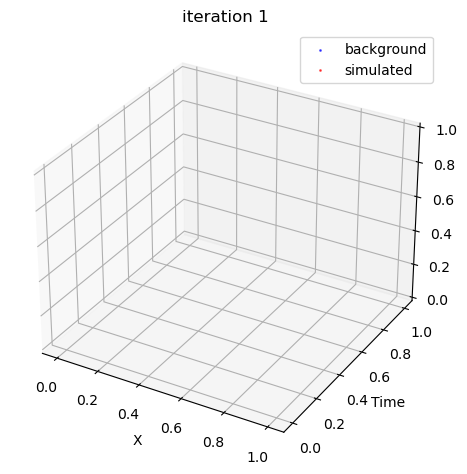

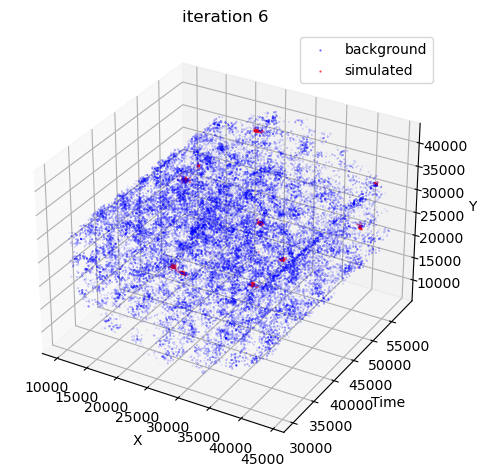

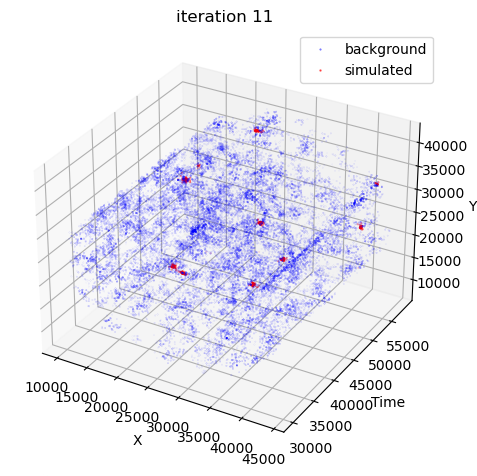

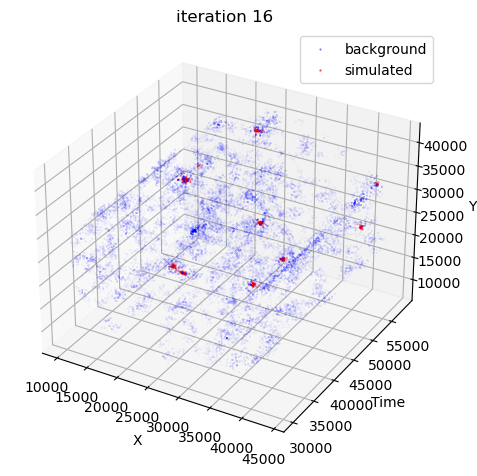

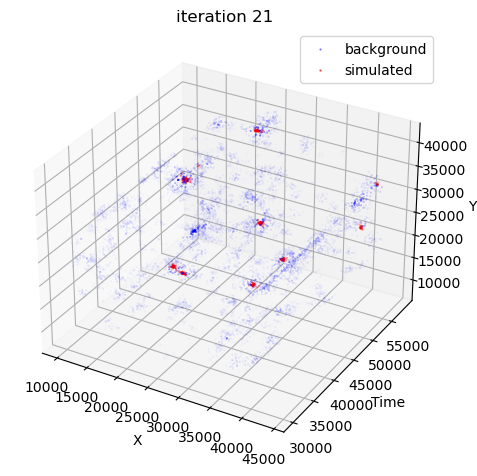

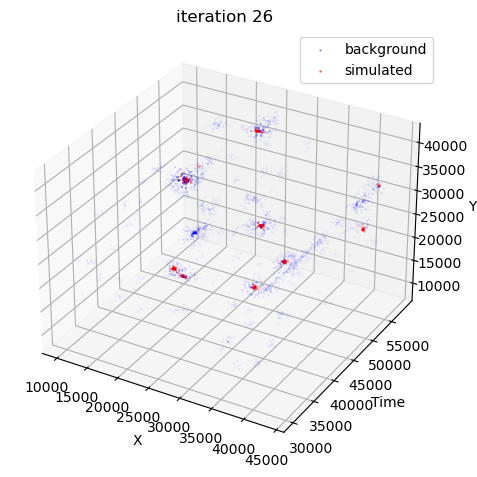

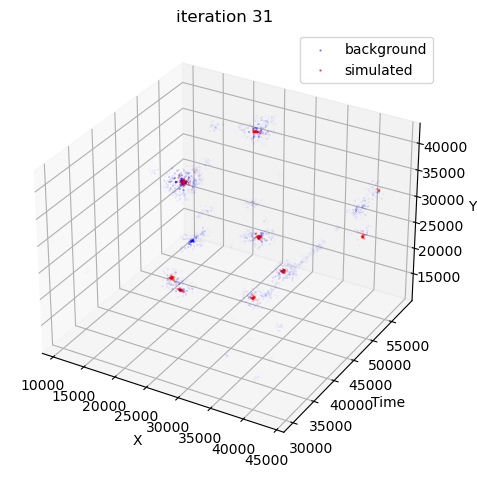

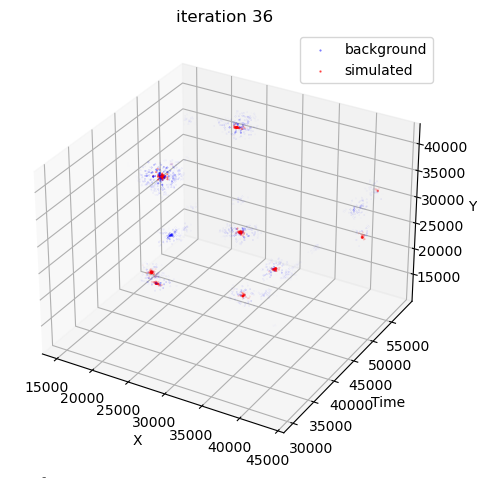

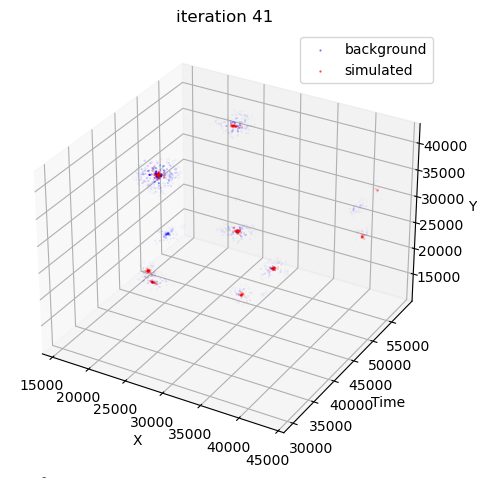

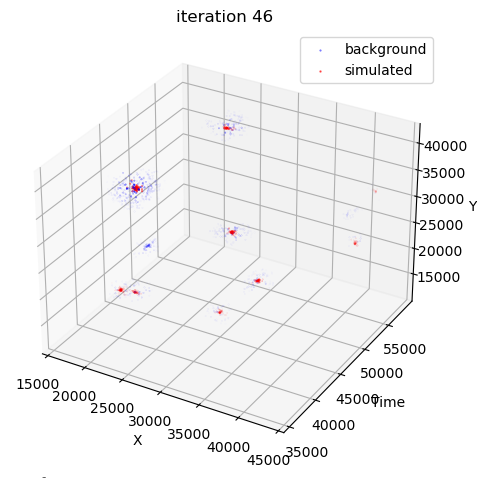

In [15]:
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ") # easy example
keys = ["X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.999
max_threshold = 0.90
filters = {"FLAG": (0,4)}
withsim = True
min_samples = 5

dataset = MPTDDataset(filename, keys, filters, withsim=withsim)
transformer = ttr.KNNGraph(k=k, force_undirected=True)
model = SimpleMessage()
elaborator = MPTDElaborator(dataset,transformer,keys,model)
eps = elaborator.distances().median().item()/2
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusterer = MPTDClusterer(algorithm=dbscan, max_threshold=max_threshold)
scorer = MPTDScorer(elaborator)
scorer.elaborator.forward_plot(iterations=layers, plot_every=5, max_threshold=max_threshold)
labels = scorer.predict_labels(clusterer)

In [ ]:
mask = labels >= 0
# masked_data = scorer.elaborator.dataset.data.getsplice(mask).cpu()
masked_data = dataset.data.getsplice(mask).cpu()
masked_sizes = scorer.elaborator.elaborated_data[mask].cpu()[:,0]
print(masked_data, masked_sizes)
data = scorer.elaborator.dataset.data.cpu()

In [ ]:
plot_data(masked_data.pos, masked_sizes, masked_data.y.bool(), keys)
plot_clusters(masked_data.pos, masked_sizes, labels[mask].squeeze(), keys, figsize=(6,6))
plot_data(data.pos, (0.0, 0.5), data.y.bool(), keys)

In [ ]:
assert False

In [ ]:
def plot_elaboration(elaborator, layers, plot_every=1, plot_after = 0, max_threshold=0.5):
    for i in range(layers):
        elaborator.forward() 
        if (i+1)%plot_every == 0 and i >= plot_after:
            sizes = elaborator.elaborated_data[:,0]
            # threshold = torch.quantile(sizes, quantile).item()
            threshold = min(sizes.mean().item(), max_threshold)
            mask = sizes >= threshold
            plot_data(elaborator.net_data.x[mask].cpu(), sizes[mask].cpu(), issimulated=elaborator.net_data.y[mask].cpu().bool(), keys=elaborator.keys, title=f"iteration {i+1}", outfile=osp.join("video_frames", f"frame_{i:02}.png"))

    return elaborator.elaborated_data[:, 0]

def get_clusters(net_data, sizes, max_threshold, clusterer):
    # threshold = torch.quantile(sizes, quantile).item()
    threshold = min(sizes.mean().item(), max_threshold)
    mask = sizes >= threshold
    masked_data = SimTransientData(x=net_data.x[mask], y= net_data.y[mask]).cpu()

    labels = clusterer.fit_predict(masked_data.x[:, 1:])
    labels_full = np.full((net_data.x.shape[0],), -1)
    labels_full[mask.cpu()] = labels

    return labels_full

In [ ]:
# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filenames = []
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M1S001MIEVLF0000.FTZ")) # easy example
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ")) # easy example
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601PNS003PIEVLF0000.FTZ")) # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.999
max_threshold = 0.90
withsim = True
min_samples = 5

raw_data = get_raw_data(filename=filenames[0], keys=keys, filters={"FLAG": (0,4)})
for filename in filenames[1:]:
    print(filename, len(raw_data))
    raw_data = astropy_table.vstack([raw_data, get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})])

issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()

if withsim:
    data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                            y = issimulated.long()).cuda()
else:
    data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                            y = issimulated[~issimulated].long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)
eps = distances.median().item()/2

model = SimpleMessage()
elaborator = MPTDElaborator(net_data, keys, model)
sizes = get_elaborated(net_data, keys, model, layers, plot_every=1, plot_after = layers-1, max_threshold=max_threshold)

dbscan = DBSCAN(eps=eps, min_samples=min_samples)

labels = get_clusters(net_data, distances, sizes, clusterer=dbscan, max_threshold=max_threshold)


In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_mean_with_errorbars(tensor, labels, time_threshold=np.inf):
    unique_labels = np.unique(labels)
    fig, ax = plt.subplots()
    colsm = plt.cm.ScalarMappable(norm=None, cmap=plt.cm.RdYlBu)
    colsm

    cbar_data = []  # Collect colorbar data
    xs = []
    xerrs = []
    ys = []
    yerrs = []
    sizes = []
    colors = []

    for label in unique_labels:
        if label == -1: continue
        indices = np.where(labels == label)[0]
        group_coords = tensor[indices]

        mean_coords = torch.mean(group_coords, dim=0)
        std_coords = torch.std(group_coords, dim=0)

        size = np.log10(len(indices))*5
        color = torch.std(group_coords[:, 1], dim=0)  # Standard deviation along the second dimension

        if color > time_threshold: continue

        cbar_data.append(color)  # Collect colorbar data
        
        # ax.errorbar(mean_coords[0], mean_coords[-1], xerr=std_coords[0], yerr=std_coords[-1],
        #             fmt='o', markersize=size, color=plt.cm.RdYlBu(color.item()), alpha=0.7)
        # print(plt.cm.RdYlBu(color.item()))

        xs.append(mean_coords[0].item())
        xerrs.append(std_coords[0].item())
        ys.append(mean_coords[-1].item())
        yerrs.append(std_coords[-1].item())
        sizes.append(size)
        colors.append(color)

    assert len(colors) == len(xs)

    colors = np.array(colors).squeeze()
    # colors /= colors.max()

    colsm.set_array(colors)

    for x, y, xerr, yerr, color, size in zip(xs, ys, xerrs, yerrs, colors, sizes):
        ax.errorbar(x, y, xerr=xerr, yerr=yerr, c=colsm.to_rgba(color, alpha=0.7), alpha=0.7, fmt='o')
    # ax.scatter(xs, ys, s=sizes, c=colors, cmap='viridis', alpha=0.7)

    ax.set_xlabel('First Dimension')
    ax.set_ylabel('Last Dimension')
    ax.set_title('Mean with Error Bars')

    # Create a colorbar
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(colsm, cax=cax)
    cbar.set_label('Standard Deviation along Second Dimension')

    plt.show()

In [ ]:
mask = labels >= 0

masked_data = SimTransientData(x=net_data.x[mask], y= net_data.y[mask]).cpu()
masked_issimulated=masked_data.y.bool()
data = data.cpu()
masked_sizes = sizes[mask].cpu()

# plot_data(data.x, (0.01, 0.5), issimulated, keys)
plot_data(masked_data.x, masked_sizes, masked_issimulated, keys)
plot_clusters(masked_data.x[:, 1:4], masked_sizes, labels[mask].squeeze(), keys[1:4], figsize=(6,6))
plot_data(data.x, (0.0, 0.5), issimulated, keys)
plot_mean_with_errorbars(masked_data.x[:, 1:4], labels, 1000)

In [ ]:
assert False

In [ ]:
label = 2
tensor = data.x[:, 1:4]
overlabels = np.full_like(mask, fill_value=-1)
overlabels[mask] = labels
epsilon = 0.
indices = np.where(labels == label)[0]
old_group_coords = tensor[indices]
coords_2d = old_group_coords[:, [0,2]]
sec = welzl(coords_2d)
print(((tensor[:, [0,2]].numpy() - np.array(sec.center))**2).sum() <= sec.radius + epsilon)
group_coords = tensor[((tensor[:, [0,2]] - torch.tensor(sec.center))**2).sum(axis=1) <= sec.radius + epsilon]
print(len(old_group_coords))
print(group_coords)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*group_coords.T, c="blue")
ax.scatter(*old_group_coords.T, c="red")

In [ ]:

def plot_light_curves(tensor, labels, time_threshold=np.inf, bins=50, epsilon=0):
    unique_labels = np.unique(labels)

    for label in unique_labels:
        if label == -1: continue
        indices = np.where(labels == label)[0]
        group_coords = tensor[indices]
        coords_2d = group_coords[:, [0,2]]
        center, radius = smallest_enclosing_circle(coords_2d)
        group_coords = tensor[euclidean(tensor[:, [0,2]], center) <= radius + epsilon]
        time_dev = torch.std(group_coords[:, 1], dim=0)  # Standard deviation along the second dimension
        if time_dev > time_threshold: continue

        plt.hist(group_coords[:, 1].numpy(), bins=bins)
        plt.xlabel("Time")
        plt.title(f"Cluster #{label}")

        plt.show()

In [ ]:
overlabels = np.full_like(mask, fill_value=-1)
overlabels[mask] = labels
plot_light_curves(data.x[:, 1:4], overlabels, bins=100)

In [ ]:
assert False

In [ ]:
import os.path as osp
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

import torch

def my_get_clusters_with_pruning(net_data, distances, model, layers, quantile, transform, plot_every=1, plot_after = 0, spectrum=True, max_threshold=0.5):
    elaborated_data = torch.ones_like(net_data.x[:, 0].unsqueeze(-1))
    # issimulated=net_data.y.bool()

    for i in range(layers):
        elaborated_data += model.forward(elaborated_data, net_data.edge_index)#, edge_weight=gaussian_kernel(distances, distances.median()*1000))
        sizes = elaborated_data[:,0]
        # threshold = torch.quantile(sizes,  quantile).item()
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        net_data = transform(SimTransientData(x=net_data.x[mask], y= net_data.y[mask]))
        if (i+1)%plot_every == 0 and i >= plot_after:
            plot_data(net_data.x.cpu(), sizes[mask].cpu(), issimulated=net_data.y.cpu().bool(), keys=keys, title=f"iteration {i+1}", outfile=osp.join("video_frames", f"frame_{i:02}.png"))
        elaborated_data /= elaborated_data.max()
        elaborated_data = elaborated_data[mask]


    masked_data = net_data.cpu()
    masked_sizes = sizes[mask].cpu()

    if spectrum:
        cluster = SpectralClustering(affinity="nearest_neighbors", n_neighbors=8, assign_labels="cluster_qr", n_jobs=-1)
        labels = cluster.fit_predict(masked_data.x[:, 1:])
    else:
        dbscan = DBSCAN(eps=distances.median().item()/2, min_samples=5)  # Adjust parameters according to your data
        labels = dbscan.fit_predict(masked_data.x[:, 1:])

    return masked_data, masked_sizes, labels, mask.cpu()

In [ ]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 30
quantile = 0.6

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                        y = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask = \
    my_get_clusters_with_pruning(net_data, distances, model, layers, quantile, transform, plot_every=5, plot_after=5, spectrum=False)

masked_issimulated=masked_data.y.bool()

In [ ]:

data = data.cpu()
issimulated = issimulated.cpu()

plot_data(data.x, (0.01, 0.5), issimulated, keys)
plot_data(masked_data.x, masked_sizes, masked_issimulated, keys)
plot_clusters(masked_data.x[:, 1:4], masked_sizes, labels, keys[1:4])
plot_data(data.x, (0.0, 0.5), issimulated, keys)

In [ ]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.99

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                        y = issimulated[~issimulated].long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask = \
    my_get_clusters_with_pruning(net_data, distances, model, layers, quantile, transform, plot_every=5, plot_after=15, spectrum=False, max_threshold=0.90)

masked_issimulated=masked_data.y.bool()

In [ ]:

data = data.cpu()
issimulated = issimulated.cpu()

plot_data(data.x, (0.01, 0.5), issimulated, keys)
plot_data(masked_data.x, masked_sizes, masked_issimulated, keys)
plot_clusters(masked_data.x[:, 1:4], masked_sizes, labels, keys[1:4])
plot_data(data.x, (0.0, 0.5), issimulated, keys)